<a href="https://colab.research.google.com/github/adasegroup/ML2020_seminars/blob/master/seminar17/active_learning_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys, json
import numpy as np
import random
import time
import pickle

from sklearn.datasets import fetch_openml
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
#
# SOURCES
#
# https://towardsdatascience.com/active-learning-tutorial-57c3398e34d
# https://hunch.net/~active_learning/active_learning_icml09.pdf
# https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html
# https://towardsdatascience.com/uncertainty-sampling-cheatsheet-ec57bc067c0b

# Active Learning

<img src="https://github.com/adasegroup/ML2020_seminars/blob/master/seminar17/pic/pool-based-AL.jpg?raw=1">

**Goal of Active Learning**: 
    1. train the best classifier/regressor using the smallest train set
    2. objects are queried and annotated from the pool sequentially

**Active Learning Heuristic**

1. Start with a pool of unlabeled data
2. Pick a few points at random and get their labels
3. Repeat the following until we have budget left for getting labels
    * Fit a classifier/regressor to the labels seen so far
    * Pick the BEST unlabeled point to get a label for
        — (closest to the boundary?)
        — (most uncertain?)
        — (most likely to decrease overall uncertainty?)

# Active Learning for Regression

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [6]:
X, y = datasets.load_boston(return_X_y = True)

In [7]:
X.shape

(506, 13)

In [8]:
y.shape

(506,)

In [9]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [10]:
N = X_full_train.shape[0]

In [11]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

**MaxVarianceSelector**

$argmax_{i} \sigma(x_i | X)$

$\sigma(x_i | X)$ comes from Guassin Process Regression

In [ ]:
# indices - ids of labeled points
# X_full_train - all dataset (pool)
# X_train - X of labeled points
# y_train - y of labeled points
# X_test, y_test - test dataset

In [37]:
def MaxVarianceSelector(indices, X_full_train, X_train, y_train, X_test, y_test):
    
    gpr = GaussianProcessRegressor(kernel = RBF(), random_state = 0)
    gpr.fit(X_train, y_train)
    
    mean, var = gpr.predict(X_full_train, return_std = True)

    best_new_idx = -1
    max_var = -1
    
    for i in range(len(X_full_train.shape[0])):
        if var[i] > max_var and i not in indices:
            best_new_idx = i
            max_var = var[i]
    
    return best_new_idx

**MaxMinDistance**

$argmax_{i} d_i$

$d_i = min_{x \in X\_labeled} ||x_i - x||$ 

$d_i$ - is minimum distance to labeled points

In [38]:
def MaxMinDistanceSelector(indices, X_full_train, X_train, y_train, X_test, y_test):

    d_min_max = -1
    best_new_idx = -1
    
    for i in range(X_full_train.shape[0]):
        
        d_min = 1e6
        
        if i not in indices:
            for j in range(X_train.shape[0]):
                d = np.linalg.norm(X_full_train[i] - X_train[j])
                d_min = min(d, d_min)

            if d_min > d_min_max:
                best_new_idx = i
                d_min_max = d_min
        
    return best_new_idx

In [39]:
def evaluate_criterion(func):

    n_init = 5
    indices = list(np.random.choice(N, size = 5, replace = False))
    errors = np.zeros(N)
    errors[0:n_init] = None

    while len(indices) < N:

        X_train = X_full_train[indices]
        y_train = y_full_train[indices]

        best_new_idx = func(indices, X_full_train, X_train, y_train, X_test, y_test)

        indices.append(best_new_idx)

        #
        # Evaluation
        #
        rf = RandomForestRegressor(n_estimators = 100)
        rf.fit(X_train, y_train)

        mean_test = rf.predict(X_test)

        rmse = pow(((mean_test - y_test)**2).mean(axis=None), 0.5)
        errors[len(indices)-1] = rmse
        
    return errors

In [44]:
trials = 20

error_MaxMinDistance = np.zeros(N)
error_MaxVariance = np.zeros(N)
    
for i in range(trials):
    error_MaxMinDistance += evaluate_criterion(MaxMinDistanceSelector)
    error_MaxVariance += evaluate_criterion(MaxVarianceSelector)
    
error_MaxMinDistance /= N
error_MaxVariance /= N

/home/trofim/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00206096]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)
/home/trofim/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.37482707]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 35, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


In [51]:
#with open('adoe.pickle', 'wb') as outfile:
#    pickle.dump([error_MaxMinDistance, error_MaxVariance], outfile)

In [52]:
with open('adoe.pickle', 'rb') as infile:
    [error_MaxMinDistance, error_MaxVariance] = pickle.load(infile)

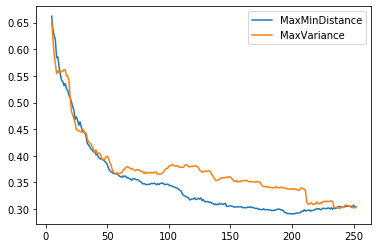

In [53]:
ax = plt.plot(range(len(error_MaxMinDistance)), error_MaxMinDistance, label = 'MaxMinDistance')
ax = plt.plot(range(len(error_MaxVariance)), error_MaxVariance, label = 'MaxVariance')
plt.legend()

# Active Learning for Classification

# Uncertainty Estimation Functions

(0, 1)

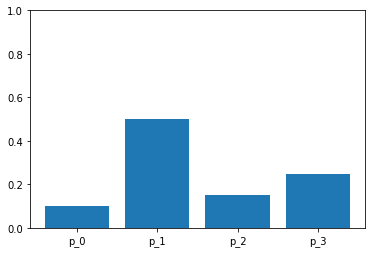

In [54]:
p = [0.1, 0.5, 0.15, 0.25]

ax = plt.bar(range(4), height = p, tick_label = ['p_%d' % i for i in range(4)])
plt.ylim((0,1))

## 1. Least Confidence

$ SCORE = 1 - {max}_{i} P_i$

In [55]:
idx = np.argmax(p)
unc = [(1-p[i] if i == idx else 0) for i in range(4)]

(0, 1)

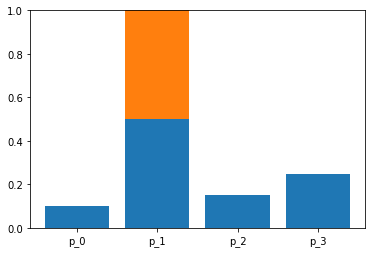

In [56]:
ax = plt.bar(range(4), height = p, tick_label = ['p_%d' % i for i in range(4)])
ax = plt.bar(range(4), height = unc, bottom = p)
plt.ylim((0,1))

* What is the maximum "least cofidence" ?

## 2. Margin of confidence

$ SCORE = 1 - (P_{i1} - P_{i2})$

$P_{i1}, P_{i2}$ - top1 and top2 probabilities

In [57]:
idx2, idx1 = np.argsort(p)[-2:]
margin = p[idx1] - p[idx2]
unc = [(margin if i == idx2 else 0) for i in range(4)]

(0, 1)

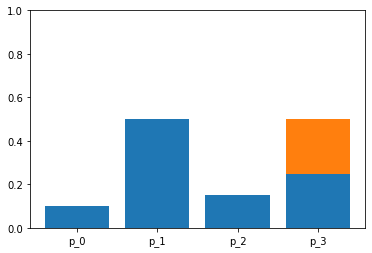

In [58]:
ax = plt.bar(range(4), height = p, tick_label = ['p_%d' % i for i in range(4)])
ax = plt.bar(range(4), height = unc, bottom = p)
plt.ylim((0,1))

* What is the maximum "margin of cofidence" ?

## 3. Entropy

$ SCORE = -\sum_i P_i \log P_i $

* What is the maximum "Entropy" ?

## Experiments with MNIST

In [59]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [60]:
X.shape

(70000, 784)

In [61]:
train_size = 60000

In [62]:
X_train_full = X[:train_size]
y_train_full = np.ndarray.astype(y[:train_size], int)
X_test = X[train_size:]
y_test = np.ndarray.astype(y[train_size:], int)

In [63]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass

class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=100, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

In [64]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., 
    # we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:', i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')

In [65]:
class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass

class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

        return selection

class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection
      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection
    
class RatioSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] / rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection
    
class LeastConfidenceSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection

In [66]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):

    permutation = np.random.choice(X_train_full.shape[0],
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape)

    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

In [67]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)
            
            print(uncertain_samples)
            print(probas_val[uncertain_samples])


            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)

In [68]:
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10


In [69]:
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    #pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d

In [70]:
max_queried = 500 
repeats = 1

models = [RfModel]

selection_functions = [RandomSelection, MarginSamplingSelection, RatioSamplingSelection, EntropySelection, LeastConfidenceSelection] 

Ks = [10] 

In [71]:
#
# NB! Execution takes long time
#
d = {}
stopped_at = -1 

d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)

stopping at: 500
Count = 1, using model = RfModel, selection_function = RandomSelection, k = 10, iteration = 0.

initial random chosen samples (10,)
initial train set: (10, 784) (10,) unique(labels): [1 1 1 1 1 0 2 0 2 1] [0 1 2 3 4 6 8 9]
val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.914 s 

Accuracy rate for 33.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
 

/home/trofim/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [0 0 6 ... 6 1 8]
probabilities: (59990, 8) 
 [0 0 5 ... 5 1 6]
[36849 11134 13621 29501 57757 18503 17894 41852 37454  6122]
[[0.03 0.16 0.04 0.12 0.04 0.18 0.21 0.22]
 [0.02 0.38 0.06 0.07 0.05 0.2  0.14 0.08]
 [0.09 0.27 0.06 0.07 0.17 0.14 0.14 0.06]
 [0.2  0.09 0.07 0.18 0.07 0.1  0.13 0.16]
 [0.13 0.16 0.07 0.05 0.04 0.16 0.22 0.17]
 [0.2  0.18 0.04 0.12 0.04 0.13 0.18 0.11]
 [0.09 0.15 0.04 0.06 0.06 0.16 0.13 0.31]
 [0.07 0.25 0.14 0.08 0.06 0.18 0.15 0.07]
 [0.07 0.22 0.07 0.13 0.02 0.28 0.12 0.09]
 [0.04 0.31 0.05 0.07 0.1  0.2  0.15 0.08]]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [1 4 1 2 1 1 3 1 4 2] [0 1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.989 s 



val predicted: (59960,) [3 0 2 ... 5 2 8]
probabilities: (59960, 10) 
 [3 0 2 ... 5 2 8]
[18117 33639 37613  3187  6211 46309 18745 54200 14479 35471]
[[0.16 0.03 0.07 0.07 0.06 0.13 0.14 0.08 0.19 0.07]
 [0.07 0.26 0.12 0.16 0.02 0.03 0.12 0.03 0.16 0.03]
 [0.03 0.17 0.12 0.16 0.02 0.03 0.06 0.1  0.15 0.16]
 [0.08 0.1  0.2  0.02 0.01 0.08 0.08 0.05 0.25 0.13]
 [0.06 0.03 0.13 0.17 0.   0.13 0.06 0.07 0.22 0.13]
 [0.05 0.33 0.13 0.04 0.   0.05 0.09 0.07 0.08 0.16]
 [0.02 0.69 0.08 0.06 0.   0.   0.04 0.01 0.03 0.07]
 [0.09 0.06 0.06 0.05 0.07 0.14 0.08 0.22 0.11 0.12]
 [0.04 0.16 0.2  0.05 0.05 0.08 0.14 0.05 0.11 0.12]
 [0.14 0.04 0.06 0.04 0.03 0.33 0.02 0.13 0.07 0.14]]
trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [4 7 7 5 3 5 5 3 7 4] [0 1 2 3 4 5 6 7 8 9]


KeyboardInterrupt: 

In [73]:
def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots()
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i])
            mean = Sum / repeats
            ax.plot(x, mean, '-', label = model_object + '-' + selection_function + '-' + str(k))
    
    ax.legend()
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    fig.set_size_inches(15,8)
    ax.grid(True)
    
    ax.set_title('Active Learning Evaluation')
    ax.set_xlabel('#samples')
    ax.set_ylabel('Accuracy')
    
    plt.show()

In [74]:
#with open('active_learning_exp.pickle', 'bw') as outfile:
#    pickle.dump(d, outfile)

with open('active_learning_exp.pickle', 'rb') as infile:
    d = pickle.load(infile)

### results of the experiment, averaged over 10 runs

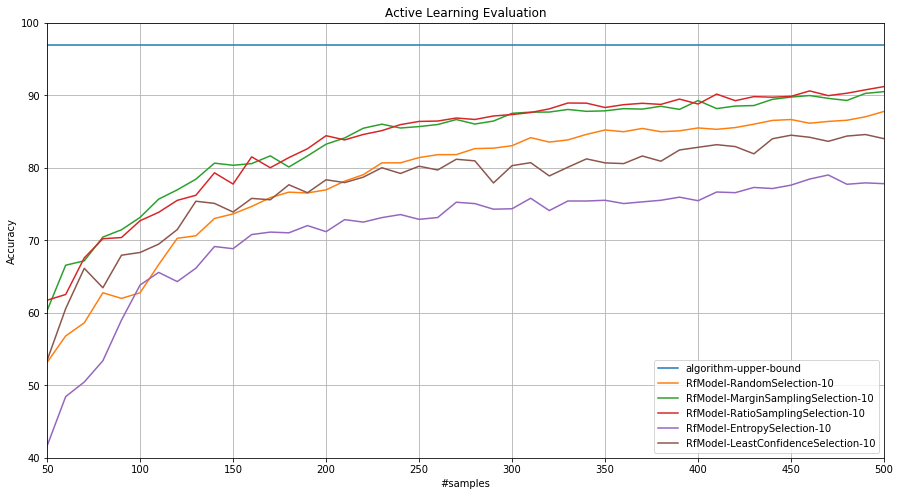

In [75]:
models_str = ['RfModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'RatioSamplingSelection',\
                           'EntropySelection', 'LeastConfidenceSelection']
Ks_str = [str(x) for x in Ks] 
repeats = 10
random_forest_upper_bound = 97.
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

performance_plot(random_forest_upper_bound, d, models_str, selection_functions_str, Ks_str, 1)

# Label Propagation

Zhu, X., & Ghahramani, Z. (2002). Learning from labeled and unlabeled data with label propagation.

*http://pages.cs.wisc.edu/~jerryzhu/pub/CMU-CALD-02-107.pdf*

Label Propagation is a semi-supervised machine learning algorithm that assigns labels to previously unlabeled data points

<img src="https://github.com/adasegroup/ML2020_seminars/blob/master/seminar17/pic/label-propagation.png?raw=1">

A) $ w_{ij} = exp(-d_{ij}^2 / \sigma^2)$ 

B) $T_{ij} = P(j \to i) = w_{ij} / \sum_{k=1}^{N} w_{kj}$

C) Y - matrix of class probalities of size N*C 

D) Smoothing (regularization): $T \to (1-\epsilon)T + \epsilon U$

**Label Propagation Algorithm**:
    
    Repeat until convergence:
1. $Y \gets TY$
2. normalize $Y$ (proper probablity distribution)
3. Clamp labeled data (use ground truth labels)

The algorithms coverges to the fixed point.

In [76]:
from sklearn.semi_supervised import LabelSpreading

In [77]:
class LabelPropagation(BaseModel):

    model_type = 'LabelProp'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        self.classifier = LabelSpreading(gamma=0.25, max_iter=20, kernel = 'knn', n_neighbors = 5)
        
        X = np.concatenate((X_train, X_val, X_test), axis = 0)
        y = np.array([int(y_train[i]) if i < X_train.shape[0] else -1 for i in range(X.shape[0])])
        
        self.classifier.fit(X, y)
        
        n1 = X_train.shape[0]
        n2 = X_val.shape[0]
        n3 = X_test.shape[0]
        
        self.test_y_predicted = self.classifier.transduction_[range(n1 + n2, n1 + n2 + n3)]
        self.val_y_predicted = self.classifier.transduction_[range(n1, n1 + n2)]
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

In [78]:
def experiment2(d, models, selection_functions, Ks, repeats, contfrom, X_train_full, y_train_full, X_test, y_test):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    #pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d

In [79]:
max_queried = 500 
repeats = 1

models = [LabelPropagation]
selection_functions = [RandomSelection, MarginSamplingSelection] 
 
Ks = [10] 

In [80]:
#
# NB! Execution takes long time
#
d = {}
stopped_at = -1 

d = experiment2(d, models, selection_functions, Ks, repeats, stopped_at+1,\
               X_train_full[:1000], y_train_full[:1000], X_test[:1000], y_test[:1000])
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)

stopping at: 500
Count = 1, using model = LabelPropagation, selection_function = RandomSelection, k = 10, iteration = 0.

initial random chosen samples (10,)
initial train set: (10, 784) (10,) unique(labels): [1 0 2 0 0 1 2 1 3] [0 2 5 6 7 8]
val set: (990, 784) (990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (990, 784)
Test  set: (1000, 784)


KeyboardInterrupt: 

In [81]:
#with open('active_learning_exp_label_prop.pickle', 'bw') as outfile:
#    pickle.dump(d, outfile)

with open('active_learning_exp_label_prop.pickle', 'rb') as infile:
    d = pickle.load(infile)

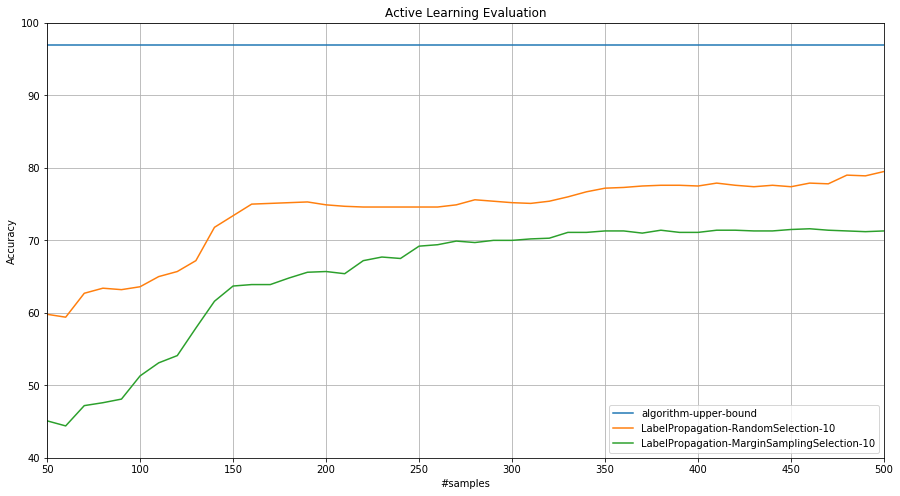

In [82]:
models_str = ['LabelPropagation']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection']
Ks_str = [str(x) for x in Ks] 
repeats = 10
random_forest_upper_bound = 97.
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

performance_plot(random_forest_upper_bound, d, models_str, selection_functions_str, Ks_str, 1)